In [6]:
import sqlite3
import logging
import cv2
import time
import os
import shutil
from ipynb.fs.full.face_recognition import *

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [7]:
def connect_to_db():
    con = sqlite3.connect("../sql_database/users.db")
    cur = con.cursor()
    cur.execute("""CREATE TABLE IF NOT EXISTS users (
        userid INTEGER PRIMARY KEY, 
        name TEXT, 
        current_user BOOLEAN
        );""") ##TODO: Add column
    cur.execute("UPDATE users SET current_user = 0;")
    return cur, con  

In [8]:
def add_new_user(cur, name):
    max_label =  cur.execute(f"SELECT MAX(userid) FROM users").fetchall()[0][0]
    if max_label:
        new_label = max_label + 1
    else:
        new_label = 1
    #make newest user as current user
    cur.execute(f"INSERT INTO users(userid, name, current_user) VALUES({new_label},'{name}', 1);")
    logging.info(f"Added new user {name} to table...")
    
    source = "current_user_images"
    destination = f"data/s{new_label}"
    
    os.mkdir(destination)
    imgs = os.listdir(source)
    for img in imgs:
        src_path = os.path.join(source, img)
        dst_path = os.path.join(destination, img)
        shutil.move(src_path, dst_path)
    
#     return name

In [9]:
def existing_user(cur, userid):
    cur.execute(f"UPDATE users SET current_user = 1 WHERE userid = {userid};")
    logging.info(f"Current user id is {userid}...")

In [10]:
def num_of_users(cur):
    num_users = cur.execute(f"SELECT COUNT(userid) FROM users").fetchall()[0][0]
    return num_users

In [11]:
def create_subjects_list(cur):
    subjects = [""]
    name_list = cur.execute(f"SELECT name FROM users order by userid").fetchall()
    name_list = [x[0] for x in name_list]
    subjects = subjects + name_list
#     logging.info(f"subjects list: {subjects}")
    return subjects

In [12]:
def close_connection(cur, con):
    con.commit()
    cur.execute(f"UPDATE users SET current_user = 0;")
    con.close()
    
    logging.info("Connection closed...")
    
    #delete images from current_user_images
#     source = "current_user_images"
#     imgs = os.listdir(source)
#     for img in imgs:
#         os.remove(f"{source}/{img}")
    shutil.rmtree("current_user_images")
    os.mkdir("current_user_images")
    logging.info("Deleted all images from folder current_user_images...")


In [20]:
def main(): 
    
    cur, con = connect_to_db()
    #capture image
    capture_image()
    logging.info("Captured images to folder current_user_images...")
#     print("NUMBER OF USERS", num_of_users(cur))
    #check if user is existing
    face_detected = False
    face_recognized = False
    label = 0
    logging.info("Predicting user...")
    img_list = os.listdir("current_user_images")
    for img in img_list:
        if img.startswith("."):
            continue
        image_path = "current_user_images/" + img
        #read image
        image = cv2.imread(image_path)
        #detect face
        face, rect = detect_face(image)
        if face is not None:
            face_detected = True
            logging.info(f"Face found in image {img}... now recognizing face")
            logging.info(f"Checking if there are no users in system currently...")
            logging.info(f"NUMBER OF USERS: {num_of_users(cur)}")
            if(num_of_users(cur) == 0):
                logging.info("0 users in system currently, breaking from loop...")
                break
            else:
                faces, labels = prepare_training_data("data")
                face_recognizer = train_model(faces, labels)
                subjects = create_subjects_list(cur)
                predicted_img, label_text, label = predict(image, face_recognizer, subjects)
                if label_text!="Unknown Person":
                    face_recognized = True
                    
        if face_detected and face_recognized:
            logging.info(f"Face recognized as user {label} {label_text}...")
            break
        elif face_detected:
            logging.info(f"Unable to RECOGNIZE face in image {img}, trying with next image...")
        else:
            logging.info(f"Unable to DETECT face in image {img}, trying with next image...")
            
    #if user exists, call existing_user() and return user name
    if face_detected and face_recognized:
        #map names and label
        name = label_text
        logging.info(f"User found: {name}")
        existing_user(cur, label)
    
    #if user does not exist call add_new_user()
    else: #else check if face detected and add
        logging.info("Adding user to database...")
#         name = input("What is your name?") ## TODO: Add "Placeholder string"
        name = "PLACEHOLDER"
        add_new_user(cur, name)
        
    ##TODO: if no face detected in at least 7 images, print no face found
    
    #emotion recognition
    
    
    close_connection(cur,con) #at the end of session

INFO:root:Captured images to folder current_user_images...
INFO:root:Predicting user...
INFO:root:Face found in image opencv0.png... now recognizing face
INFO:root:Checking if there are no users in system currently...
INFO:root:NUMBER OF USERS: {num_of_users(cur)}


['.ipynb_checkpoints', 's1']
Now in directory s1...
Now on image opencv0.png...
Now on image opencv1.png...
Now on image opencv2.png...
Now on image opencv3.png...
Now on image opencv4.png...


INFO:root:Face recognized as user 1 Esha...
INFO:root:User found: Esha
INFO:root:Current user id is 1...
INFO:root:Connection closed...
INFO:root:Deleted all images from folder current_user_images...


label: 1
conf:  54.16366836137265


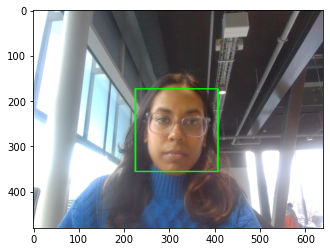

In [19]:
if __name__ == "__main__":
    main()

In [15]:
# cur, con = connect_to_db()
# cur.execute("DELETE FROM users where 1=1")
# cur.execute("DROP TABLE users")
# print(cur.execute("SELECT * FROM users").fetchall())
# print(cur.execute(f"SELECT COUNT(userid) FROM users").fetchall()[0][0])
# con.close()